# Development workbook for greenscreen script

In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
print("Environment Ready")

Environment Ready


# Make the greenscreen

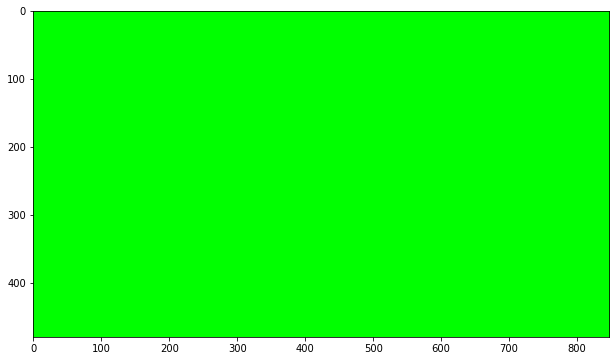

In [73]:
# Set green screen background.
DEPTH_W = 848
DEPTH_H = 480
COLOR_W = 848
COLOR_H = 480
bg_img_r = np.full((COLOR_H,COLOR_W),0)
bg_img_g = np.full((COLOR_H,COLOR_W),255)
bg_img_b = np.full((COLOR_H,COLOR_W),0)
bg_img = np.dstack((bg_img_r,bg_img_g,bg_img_b))
# rgb_uint8 = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)  # if values are b/w 0 and 1 rather than 0 and 255
bg_img
plt.imshow(bg_img)

In [18]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("object_detection.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


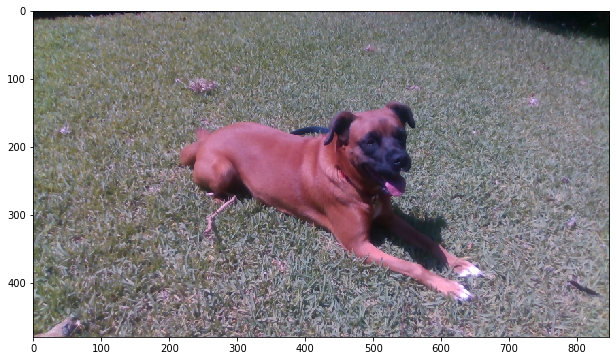

In [20]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

In [21]:
color.shape

(480, 848, 3)

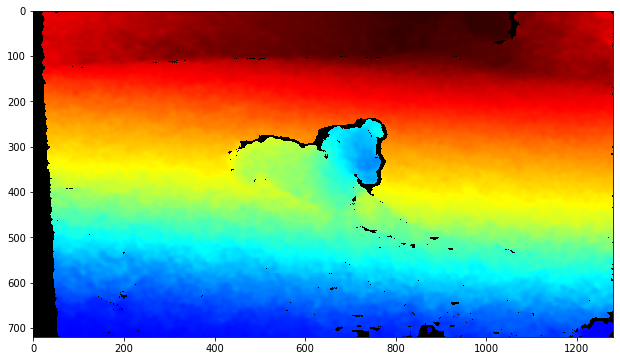

In [23]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

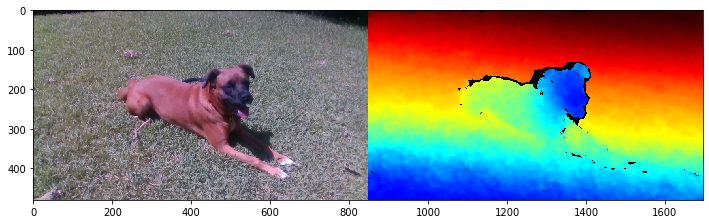

In [24]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

In [28]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
# depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a {0:.3} meters away.".format(dist))

Detected a 1.6 meters away.


In [30]:
GREENSCREEN_DEPTH = 1.5

In [36]:
clipped_depth = depth.copy()
np.clip(depth,0,1.5, out=clipped_depth)

array([[1.5       , 1.5       , 1.5       , ..., 1.5       , 1.5       ,
        1.5       ],
       [1.5       , 1.5       , 1.5       , ..., 1.5       , 1.5       ,
        1.5       ],
       [1.5       , 1.5       , 1.5       , ..., 1.5       , 1.5       ,
        1.5       ],
       ...,
       [0.83300004, 0.83400004, 0.83500004, ..., 0.92300004, 0.92200004,
        0.92100004],
       [0.83300004, 0.83400004, 0.83500004, ..., 0.92200004, 0.92000004,
        0.91800004],
       [0.83300004, 0.83300004, 0.83500004, ..., 0.92000004, 0.91900004,
        0.91700004]])

In [37]:
clipped_depth.shape

(480, 848)

In [ ]:
# now based on that... 
# query_for_each_pixel = img_rgb if depth@index <1.5 else [0,255,0]


In [ ]:
# https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
# @nb.njit(parallel=True)
# def nb_par_jitf(x):
#     y=np.empty(x.shape)
#     for i in nb.prange(len(x)):
#         y[i]=x[i]+2*x[i]*x[i]+4*x[i]*x[i]*x[i]
#     return y

In [84]:
import numba as nb
@nb.njit(parallel=True)
def assemble_greenscreen_img(rs_img, bg_img, depth_array, green_screen_threshold=GREENSCREEN_DEPTH):
    output_img=np.empty(rs_img.shape).astype(np.uint8)
    for i in nb.prange(rs_img.shape[0]):
        for j in nb.prange(rs_img.shape[1]):
            if depth_array[i,j] < green_screen_threshold:
                output_img[i,j] = rs_img[i,j].astype(np.uint8)
            else:
                output_img[i,j] = bg_img[i,j].astype(np.uint8)
    return output_img

In [85]:
merged_img = assemble_greenscreen_img(color,bg_img, depth)
print(f"{merged_img[0,1]}, {color[0,1]}, {bg_img[0,1]}")


[  0 255   0], [18 21 20], [  0 255   0]


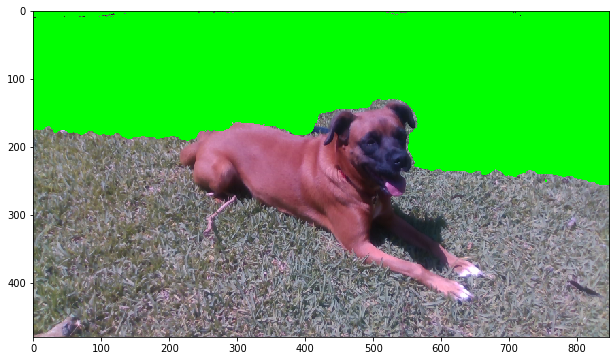

In [86]:
plt.imshow(merged_img)